### Simple 1D approach with a new ESPRESO-inspired idea. Instead of learning a convolution, we directly learn $\text{argmin}_A ||y - Ax||$ where $y \in \mathbb{R}^n$ and $x \in \mathbb{R}^m$ and $n < m$; $y$ and $x$ are 1D.

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
cd ../kaisr/

/home/remedios/kaisr/kaisr


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from pathlib import Path
import nibabel as nib

from utils.plot import *
# from utils.train_loader_1D import *
from tqdm import tqdm

In [31]:
set_display_mode('dark')

In [32]:
lr_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_04x_aniso/sub-OAS30003_ses-d0558_run-01_T1w.nii")
lr_vol = nib.load(lr_fpath).get_fdata(dtype=np.float32)

gt_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_iso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
gt_vol = nib.load(gt_fpath).get_fdata(dtype=np.float32)

In [33]:
lr_vol = np.pad(lr_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))
gt_vol = np.pad(gt_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))

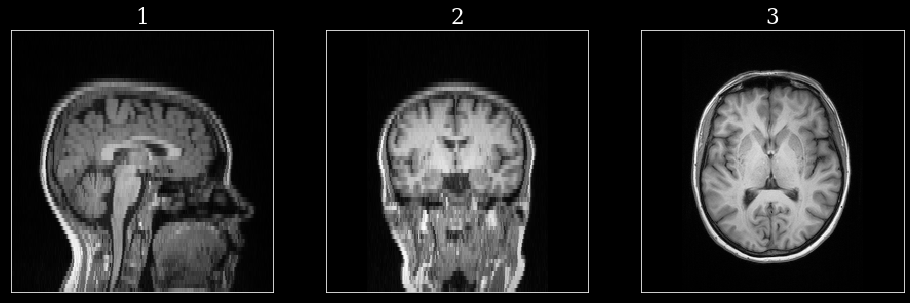

In [34]:
center_vol_plot(lr_vol, target_shape=gt_vol.shape)

In [8]:
n_iters = 10000
batch_size = 2**14
device = device = torch.device(f'cuda:0')

# $\text{argmin}_A||y - Ax||$ means we rearrange the volume as two batches

In [9]:
ds = TrainSet(fpath=lr_fpath, n_iters=n_iters * batch_size, lr_dim=2)
dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=False, # `TrainSet.__getitem__` automatically shuffles 
    pin_memory=True,
    num_workers=4,
)

# Make a small neural network generate A

In [10]:
class Generator(nn.Module):
    def __init__(self, features, z_dim, out_dim_1, out_dim_2):
        super().__init__()

        self.body = nn.Sequential(
            nn.Linear(z_dim, features),
            nn.LeakyReLU(),
            nn.Linear(features, features),
            nn.LeakyReLU(),
            nn.Linear(features, out_dim_1 * out_dim_2),
        )


    def forward(self, x):
        return self.body(x)
    
    
class Discriminator(nn.Module):
    def __init__(self, features, lr_dim):
        super().__init__()

        self.body = nn.Sequential(
            nn.Linear(lr_dim, features),
            nn.LeakyReLU(inplace=True),
            nn.Linear(features, features),
            nn.LeakyReLU(inplace=True),
            nn.Linear(features, 1),
            nn.Sigmoid(),
        )


    def forward(self, x):
        return self.body(x)

In [11]:
z_dim = 256
features = 256

In [12]:
G = Generator(features=features, z_dim=z_dim, out_dim_1=64, out_dim_2=256).to(device)
D = Discriminator(features=features, lr_dim=64).to(device)
z = torch.randn(z_dim, device=device)

In [13]:
# A = torch.randn((64, 256), requires_grad=True, device=device)
opt_G = torch.optim.Adam([z] + list(G.parameters()), lr=1e-4)
opt_D = torch.optim.Adam(D.parameters(), lr=1e-4)

loss_fn = torch.nn.BCELoss()

discrim_freq = 5

In [14]:
real_labels = torch.ones((batch_size, 1), requires_grad=False).to(device)
fake_labels = torch.zeros((batch_size, 1), requires_grad=False).to(device)

with tqdm(total=n_iters) as pbar:
    pbar_dict = {
        'loss_G': np.finfo(np.float32).max,
        'loss_D': np.finfo(np.float32).max,
    }
    for cur_step, (ys_cpu, xs_cpu) in enumerate(dataloader):
        N = ys_cpu.shape[0]

        ys = ys_cpu.to(device)
        xs = xs_cpu.to(device)

        # freeze D
        for p in D.parameters():
            p.requires_grad = False
        # generate A
        opt_G.zero_grad()
        A = G(z).view(64, 256)
        # make a fake
        ys_hat = A@xs.T
        # step G through D as if these are "real"
        loss_G = loss_fn(D(ys_hat.T), real_labels[:N])
        loss_G.backward()
        opt_G.step()
        
        if cur_step % discrim_freq == 0:
            # Discriminate
            # unfreeze D
            # unfreeze the discriminator
            for p in D.parameters():
                p.requires_grad = True
            opt_D.zero_grad()
            if np.random.rand() < 0.5:
                loss_D = loss_fn(D(ys_hat.T.detach()), fake_labels[:N])
            else:
                loss_D = loss_fn(D(ys), real_labels[:N])
            loss_D.backward()
            opt_D.step()

        pbar_dict['loss_G'] = loss_G.detach().cpu().numpy().item()
        pbar_dict['loss_D'] = loss_D.detach().cpu().numpy().item()
        pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})
        pbar.update(1)

 45%|█████████████████████████████████████▌                                              | 4474/10000 [04:33<05:38, 16.34it/s, loss_G=0.7091, loss_D=0.7273]
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/remedios/miniconda3/envs/kaisr/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/home/remedios/miniconda3/envs/kaisr/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/home/remedios/miniconda3/envs/kaisr/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/remedios/miniconda3/envs/kaisr/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/home/remedios/miniconda3/envs/kaisr/lib/python3.9/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/home/reme

KeyboardInterrupt: 

# How good is our estimate of $A$?

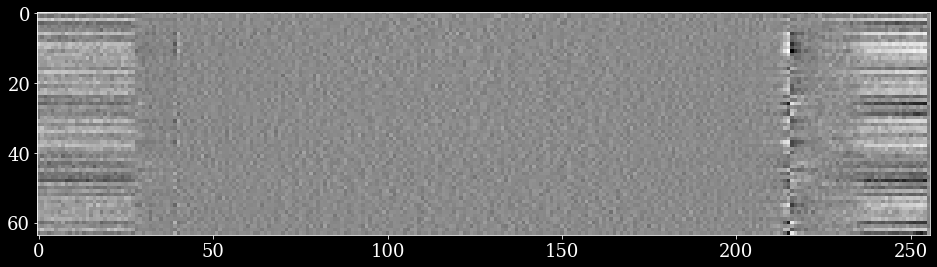

In [15]:
plt.imshow(A.detach().cpu().numpy())

In [35]:
inplane_img = lr_vol[:, :, 32]
inplane_img, *_ = normalize(inplane_img, a=0, b=1)

NameError: name 'normalize' is not defined

In [17]:
inplane_deg = (A.detach().cpu() @ inplane_img.T).T

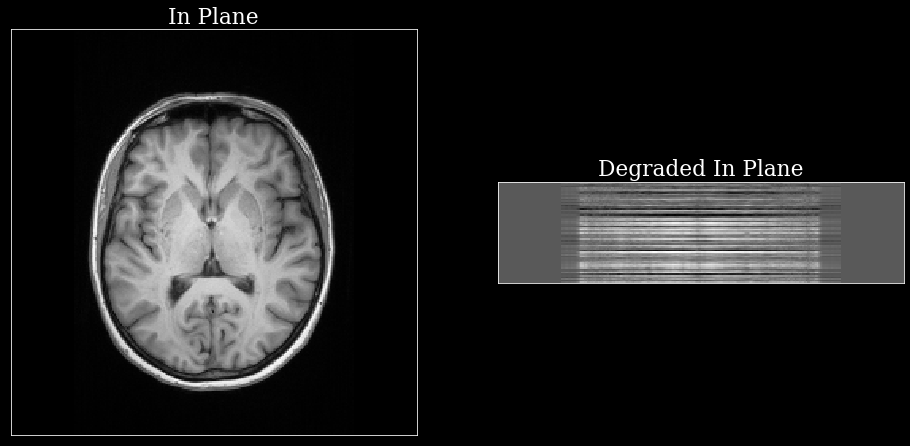

In [18]:
multiplot([inplane_img, inplane_deg], ['In Plane', 'Degraded In Plane'])

In [36]:
# degrade rows from a slice of the GT
gt_img = gt_vol[128]
gt_img, *_ = normalize(gt_img, a=0, b=1)
gt_deg = (A.detach().cpu() @ gt_img.T).T

NameError: name 'normalize' is not defined

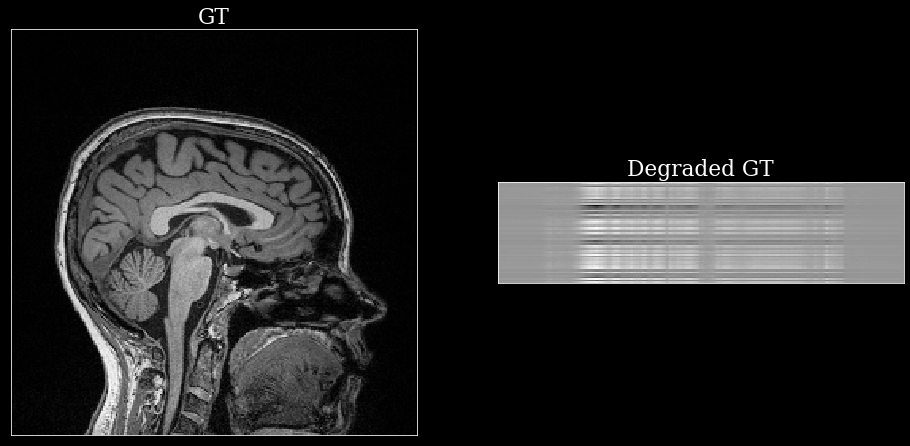

In [20]:
multiplot([gt_img, gt_deg], ['GT', 'Degraded GT'])

# Smarter Inductive Bias: $A$ is a block Toeplitz matrix constructed from shifts of the same 1D filter.

# Assumptions: 
- The downsample factor is known a priori, so we know how much to shift the filter.
- Symmetric filter, so we only need to learn half
- Filter length must be $< n$ because $A \in \mathbb{R}^{n\times m}$

In [22]:
A.shape

torch.Size([64, 256])

In [23]:
# example with a Gaussian window of length 17. How many shifts are allowed?

In [37]:
from scipy.signal import windows

In [38]:
my_filter = windows.gaussian(M=17, std=4)

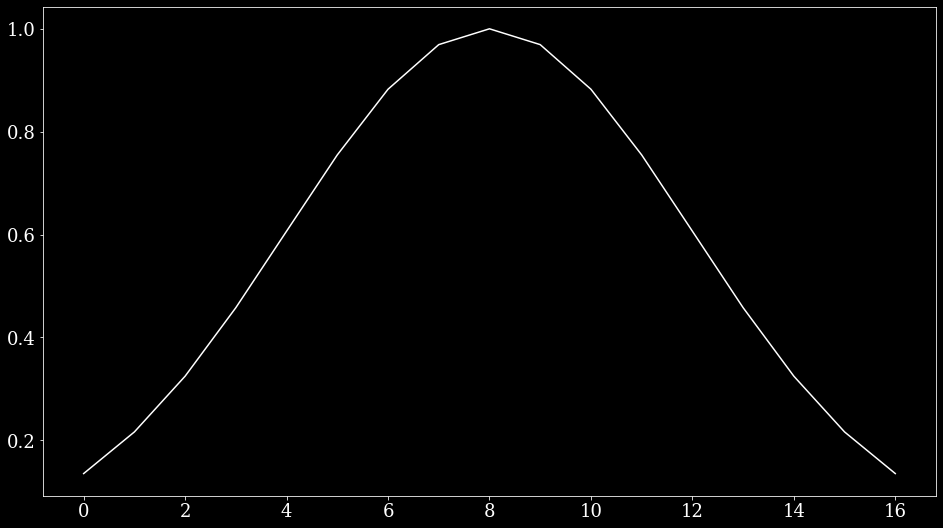

In [39]:
plt.plot(my_filter)
plt.show()

In [40]:
# With the below formulation, we can use ESPRESO to construct A

In [41]:
n = 64
m = 256
k = 17 # filter length
s = 4 # the downsampling factor is the shift

# construct a matrix A
A = np.zeros((n, m))

for i in range(64):
    # pad the filter to be of length m
    # and shift the pads
    pad = (max(0, i*s), max(0, m-k-(i*s)))
    A[i, :] = np.pad(my_filter, pad)[:m]

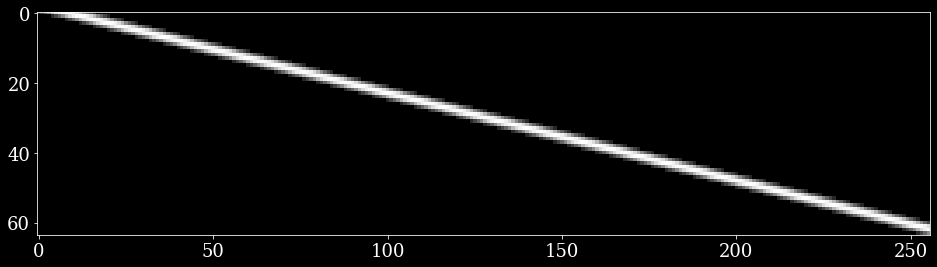

In [42]:
plt.imshow(A)
plt.show()

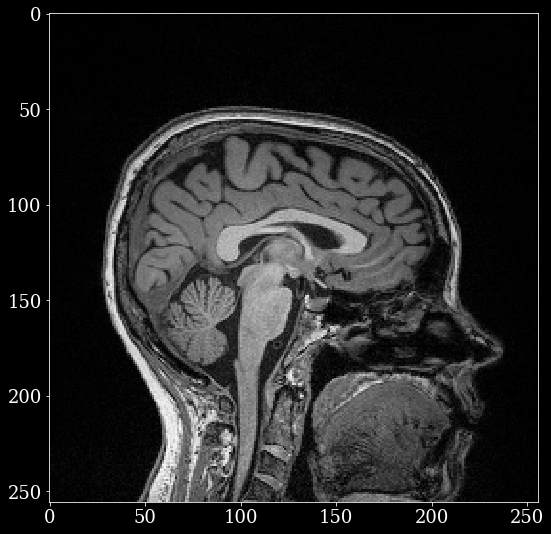

In [43]:
plt.imshow(np.rot90(gt_img))

In [44]:
(A @ gt_img).shape

(64, 256)

In [45]:
gt_img.shape

(256, 256)

In [46]:
gt_deg = (A @ gt_img.T).T

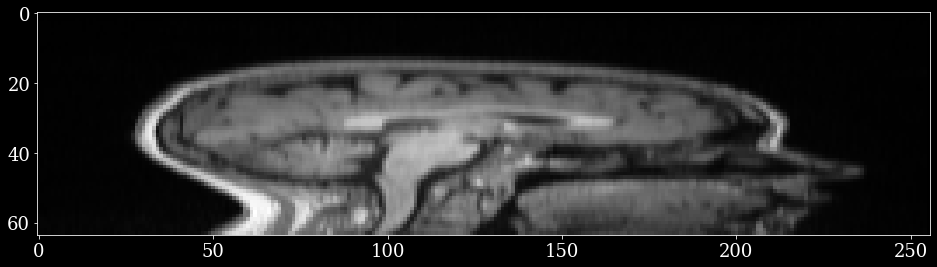

In [47]:
plt.imshow(np.rot90(gt_deg))

# Using ESPRESO to get the kernel (external to this notebook)

In [48]:
espreso_filter = np.load("../results/filters/sub-OAS30003_ses-d0558_run-01_T1w/ESPRESO2_output/result.npy")

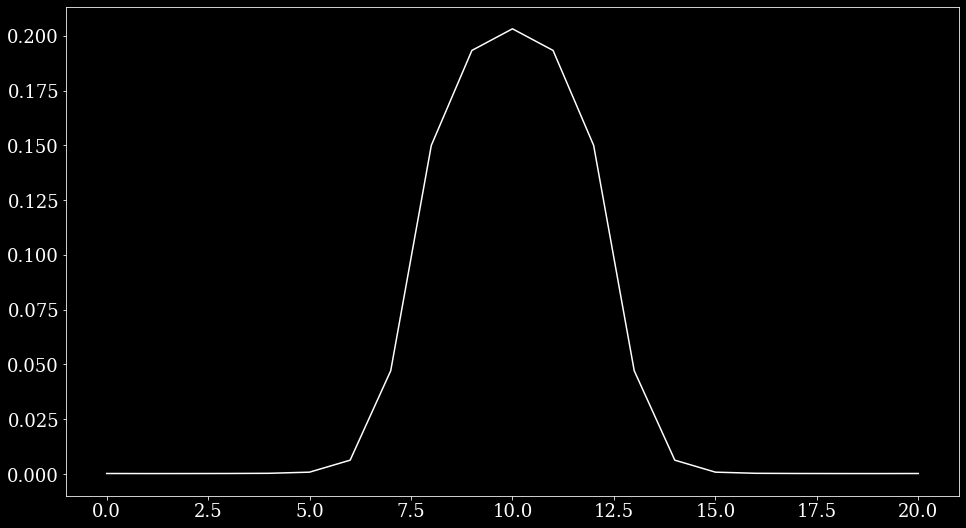

In [49]:
plt.plot(espreso_filter)

In [50]:
len(espreso_filter)

21

In [51]:
# convert to A

In [52]:
from utils.degrade import filter_as_measurement_matrix

In [53]:
B = filter_as_measurement_matrix(espreso_filter, 64, 256, 4)

In [54]:
n = 64
m = 256
k = len(espreso_filter) # filter length
s = 4 # the downsampling factor is the shift

# construct a matrix A
A = np.zeros((n, m))

for i in range(64):
    # pad the filter to be of length m
    # and shift the pads
    pad = (max(0, i*s), max(0, m-k-(i*s)))
    A[i, :] = np.pad(espreso_filter, pad)[:m]

In [69]:
A = filter_as_measurement_matrix(espreso_filter, 64, 256, 4+4)

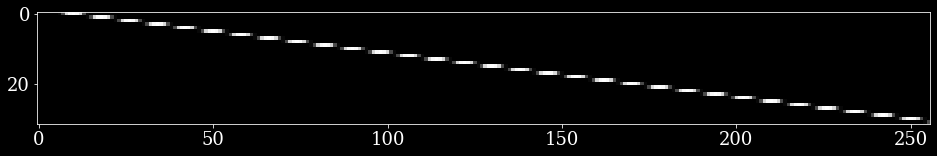

In [70]:
plt.imshow(A)

In [71]:
A.shape

torch.Size([32, 256])

In [72]:
gt_deg = (A @ gt_img.T).T

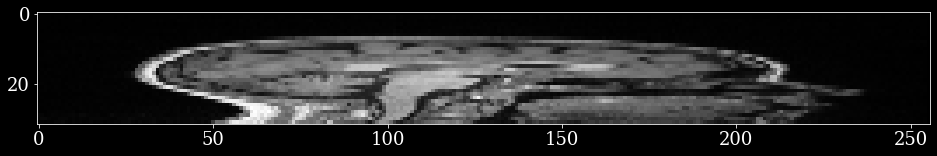

In [73]:
plt.imshow(np.rot90(gt_deg))